# Map the Time of Emergence 

In [1]:
%matplotlib inline
import os

import numpy as np
import xarray as xr

import util
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


In [2]:
ds_toe = xr.open_zarr('data/cesm-le-fields-djf-ToE-maps.zarr')
ds_toe

<xarray.Dataset>
Dimensions:        (length: 3, nlat: 93, nlon: 320)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * length         (length) float64 20.0 40.0 60.0
  * nlat           (nlat) int64 0 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90 91 92
  * nlon           (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
Data variables:
    Chl_surf       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Jint_100m_DIC  (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP            (length, nlat, nlon) float64 dask.array<chunksize=(2, 47, 320), meta=np.ndarray>
    NPP            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>

In [3]:
ds_toe = ds_toe.sel(length='40')#.where(ds_toe.KMT > 0)

In [4]:
ds_toe.KGP

<xarray.DataArray 'KGP' (nlat: 93, nlon: 320)>
dask.array<getitem, shape=(93, 320), dtype=float64, chunksize=(47, 320), chunktype=numpy.ndarray>
Coordinates:
    KMT      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length   float64 40.0
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90 91 92
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

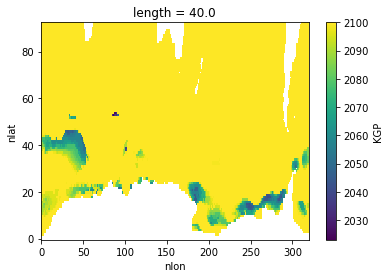

In [5]:
ds_toe.KGP.plot()

In [6]:
# Polar Plottable dsp = util.pop_add_cyclic(ds_toe)
dsp = util.pop_add_cyclic(
    
    xr.Dataset({
        'CHL': ds_toe.Chl_surf,
        'SST': ds_toe.SST,
        'KGP': ds_toe.KGP,
        'TLAT': ds_toe.TLAT.values,
        'TLONG': ds_toe.TLONG.values} ))

dsp

dsp = ds_toe

lon, lat = dsp.TLONG, dsp.TLAT 
field = dsp.SST

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())


cmap = cmocean.cm.curl
levels = np.arange(-2, 30, 1)

cf = ax.contourf(lon, lat, field,
                 cmap=cmap,
                 extend='both',
                 levels=levels,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()



MissingDimensionsError: cannot set variable 'TLAT' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

# PLOTTING FROM KRISTEN

In [8]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import esmlab
from glob import glob
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
import esmlab
import warnings
warnings.filterwarnings('ignore')
import ncar_jobqueue
from dask.distributed import Client
import cmocean
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [10]:
#SST
lon, lat, field_sst = adjust_pop_grid(ds_toe.TLONG.values, ds_toe.TLAT.values,ds_toe.SST.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_sst = field_sst[sh, :]


In [11]:
#CHL
lon, lat, field_chl = adjust_pop_grid(ds_toe.TLONG.values, ds_toe.TLAT.values,ds_toe.Chl_surf.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_chl = field_chl[sh, :]


In [12]:
#KGP
lon, lat, field_kgp = adjust_pop_grid(ds_toe.TLONG.values, ds_toe.TLAT.values,ds_toe.KGP.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_kgp = field_kgp[sh, :]

In [13]:
np.arange(1920, 2110, 5)

array([1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970,
       1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025,
       2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080,
       2085, 2090, 2095, 2100, 2105])

In [14]:
cmap = cmocean.cm.deep_r
levels = np.arange(1920, 2110, 10)
prj = ccrs.SouthPolarStereo()


In [15]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [16]:
def mesh_plot(field):
    prj = ccrs.SouthPolarStereo()
    # filled contours
    cf = ax.contourf(lon, lat, field,
                     levels = levels,
                     cmap = cmap,
                     extend = 'max',
                     transform=ccrs.PlateCarree())

    #cs = ax.contourf(lon, lat, field,
    #                colors='k', 
     #               levels = [2020,2020.6],
      #              linewidths=5, alpha = .5,
      #              transform = ccrs.PlateCarree())

    #lb = plt.clabel(cs, fontsize=10, inline=True)
        
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=1, linestyle='--').n_steps = 90 # this makes them rounder
    return cf

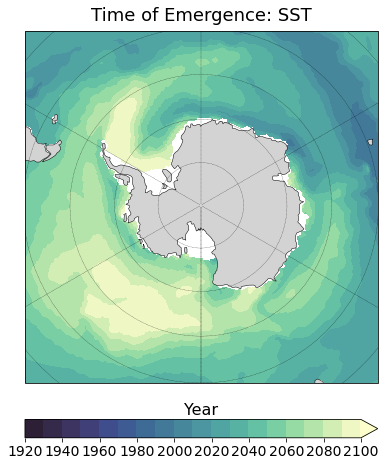

In [17]:
title = 'Time of Emergence: SST'
unit = 'Year'
name = 'SST-EM'

fig = plt.figure(figsize=(7, 12))
gs = gridspec.GridSpec(2,1, height_ratios=[2,0.1])
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

cf = mesh_plot(field_sst)

ax.set_title(f'{title}', fontsize = 18,pad=10)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}', labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.15, wspace= 0.16, bottom=0.4, left=.2, right = .9)

# --------------------------------------------------------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');


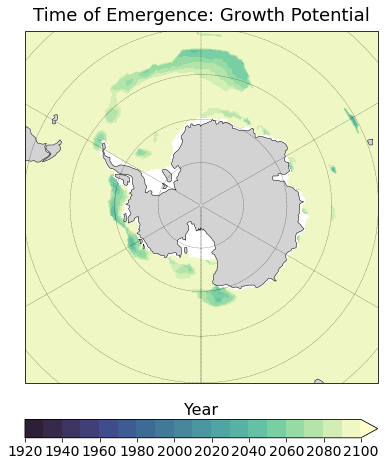

In [18]:
title = 'Time of Emergence: Growth Potential'
unit = 'Year'
name = 'GP-EM'
to_plot = field_kgp

fig = plt.figure(figsize=(7, 12))
gs = gridspec.GridSpec(2,1, height_ratios=[2,0.1])
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

cf = mesh_plot(to_plot)

ax.set_title(f'{title}', fontsize = 18,pad=10)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}', labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.15, wspace= 0.16, bottom=0.4, left=.2, right = .9)

# --------------------------------------------------------
path = 'figures/'
file = '.pdf'
#plt.savefig(path + name + file, bbox_inches='tight');


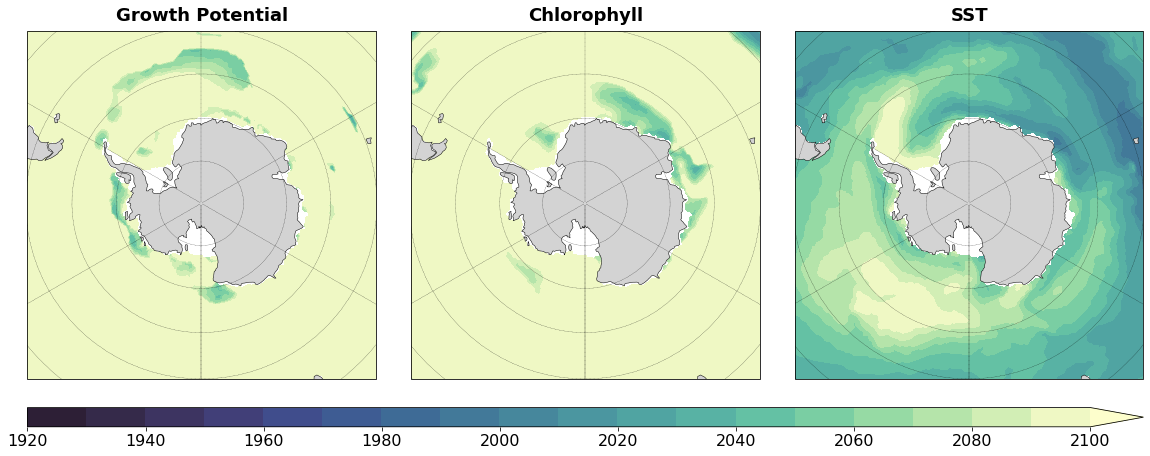

In [17]:
title = 'horizontal TOE EM'
a, b, c = 'Growth Potential', 'Chlorophyll', 'SST'

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.1])
######################  PLOTS  #############################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_kgp)
ax.set_title(f'{a}', fontsize = 18, fontweight = 'bold',pad=10)

# --------------------------------------------------------

ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_chl)
ax.set_title(f'{b}', fontsize = 18, fontweight = 'bold',pad=10)

# --------------------------------------------------------

ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_sst)
ax.set_title(f'{c}', fontsize = 18, fontweight = 'bold',pad=10)

#####################  COLOR BAR  ###########################

cbax = plt.subplot(gs[1,:]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', extend = 'right')#, ticklocation = 'top')
#cb.set_label('Years', labelpad=5, fontsize = 1)
#cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=16)

#####################  EXTRAS  ##############################
ax = fig.get_axes()
gs.update(hspace=0.05, wspace= 0.1, bottom=0.4)

#####################  SAVE  ##############################

path = 'figures/'
file = '.png'
plt.savefig(path + title + file, bbox_inches='tight')

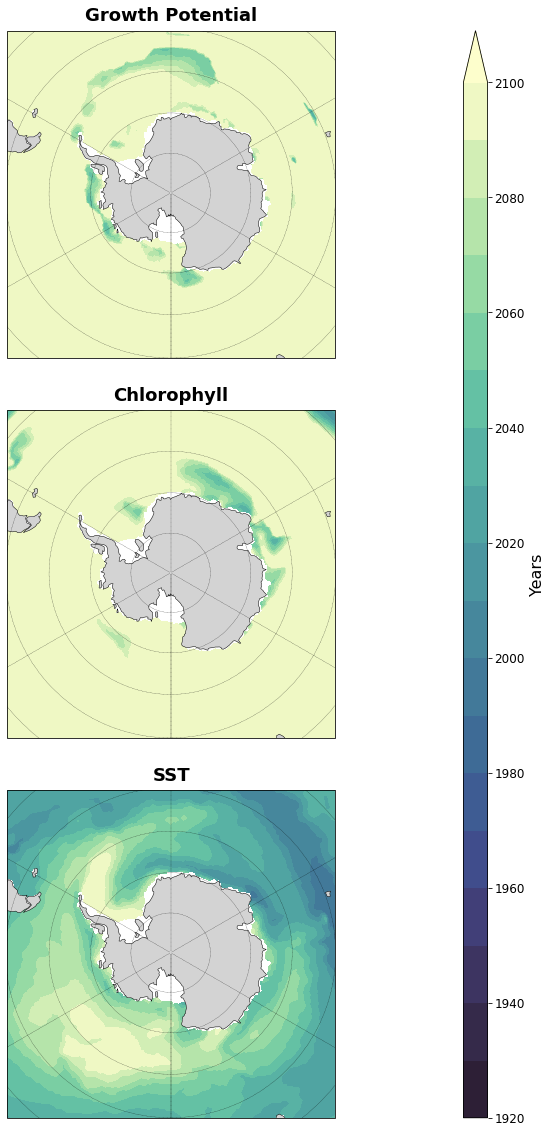

In [20]:
title ='Vertical-TOE-Plots-EM'
a, b, c = 'Growth Potential', 'Chlorophyll', 'SST'
fig = plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.05])

######################  PLOTS  #############################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_kgp)
ax.set_title(f'{a}', fontsize = 18, fontweight = 'bold',pad=10)

# --------------------------------------------------------

ax = fig.add_subplot(gs[1, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_chl)
ax.set_title(f'{b}', fontsize = 18, fontweight = 'bold',pad=10)

# --------------------------------------------------------

ax = fig.add_subplot(gs[2, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_sst)
ax.set_title(f'{c}', fontsize = 18, fontweight = 'bold',pad=10)

#####################  COLOR BAR  ###########################

cbax = plt.subplot(gs[:,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', extend = 'max')#, ticklocation = 'top')
cb.set_label('Years', labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)


#####################  EXTRAS  ##############################
ax = fig.get_axes()
gs.update(hspace=0.16)#, wspace= .05, bottom=0.4)

#####################  SAVE  ##############################

path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

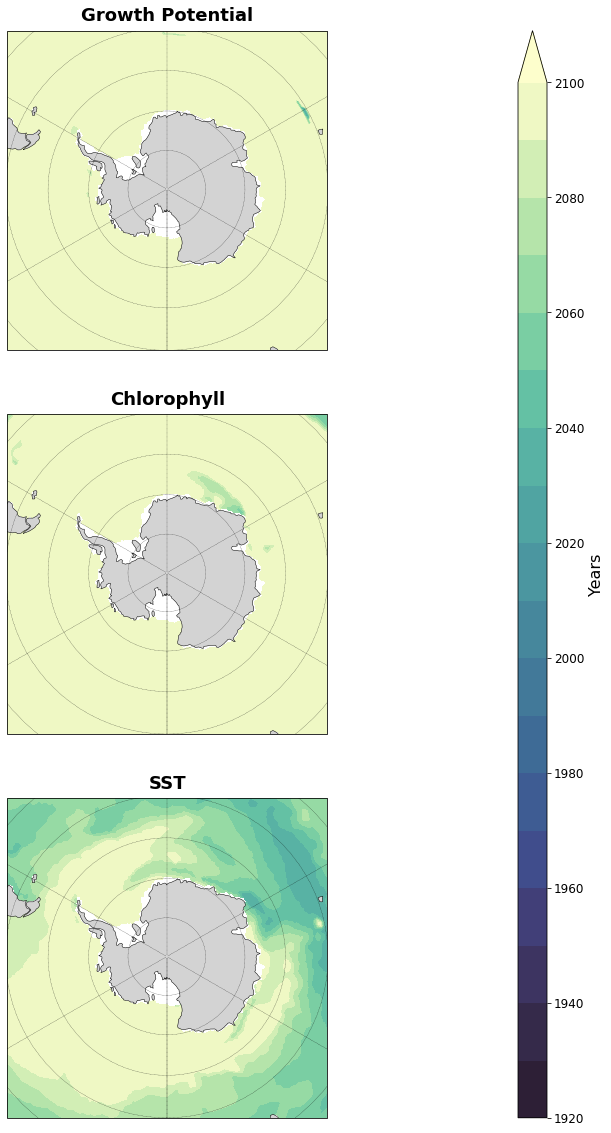

In [20]:
a, b, c = 'Growth Potential', 'Chlorophyll', 'SST'
fig = plt.figure(figsize=(12, 20))
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.05])

######################  PLOTS  #############################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_kgp)
ax.set_title(f'{a}', fontsize = 18, fontweight = 'bold',pad=10)

# --------------------------------------------------------

ax = fig.add_subplot(gs[1, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_chl)
ax.set_title(f'{b}', fontsize = 18, fontweight = 'bold',pad=10)

# --------------------------------------------------------

ax = fig.add_subplot(gs[2, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = mesh_plot(field_sst)
ax.set_title(f'{c}', fontsize = 18, fontweight = 'bold',pad=10)

#####################  COLOR BAR  ###########################

cbax = plt.subplot(gs[:,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', extend = 'max')#, ticklocation = 'top')
cb.set_label('Years', labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)


#####################  EXTRAS  ##############################
ax = fig.get_axes()
#gs.update(hspace=0.16)#, wspace= .05, bottom=0.4)

#####################  SAVE  ##############################

path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(6,12))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')

#---------- PIC from satellite
ax = fig.add_subplot(2,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.set_title('a) CESM SST °C')
pc=ax.pcolormesh(lon, lat, field_sst,
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual PIC (mmol m$^{-3}$)')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
#----------
ax = fig.add_subplot(2,1,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) CESM surface Chl mg m$^3$')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.pcolormesh(lon, lat, field_chl,
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual CaCO$_3$ (mmol m$^{-3}$)')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
###############################
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='Year')#,aspect=50)
#----------
ax = fig.add_subplot(2,1,2, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Growth Potential SST °C')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.pcolormesh(lon, lat, field_sst,
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual CaCO$_3$ (mmol m$^{-3}$)')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
###############################
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='Year')#,aspect=50)



#fig.subplots_adjust(right=0.8,hspace=0.1)
fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)

#fig.subplots_adjust(hspace=0.1)


# Plotting Setup

In [40]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


In [56]:
# Colors and Projection
cmap = cmocean.cm.curl_r

level_p = [0, 0.16]
levels = np.linspace(-0.2, 0.2, 11)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()


In [57]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [136]:
def matt_plot(da):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     transform=ccrs.PlateCarree())

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [137]:
dsp = ds_toe
v = 'KGP'
title = '95% of Mean Anomoly Variance?'
name = (f'{v}')
unit = '$\Delta$ mm day$^{-1}$'

fig = plt.figure(figsize=(7, 12))
gs = gridspec.GridSpec(2,1, height_ratios=[2,0.1])
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

cf = matt_plot(dsp[v])

ax.set_title(f'{title}', fontsize = 18,pad=10)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}', labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.15, wspace= 0.16, bottom=0.4, left=.2, right = .9)

# --------------------------------------------------------
path = 'figures/'
file = '.pdf'
#plt.savefig(path + name + file, bbox_inches='tight');


ValueError: Sequences of multi-polygons are not valid arguments

ValueError: Sequences of multi-polygons are not valid arguments

<Figure size 504x864 with 1 Axes>